# Explore here

     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  20

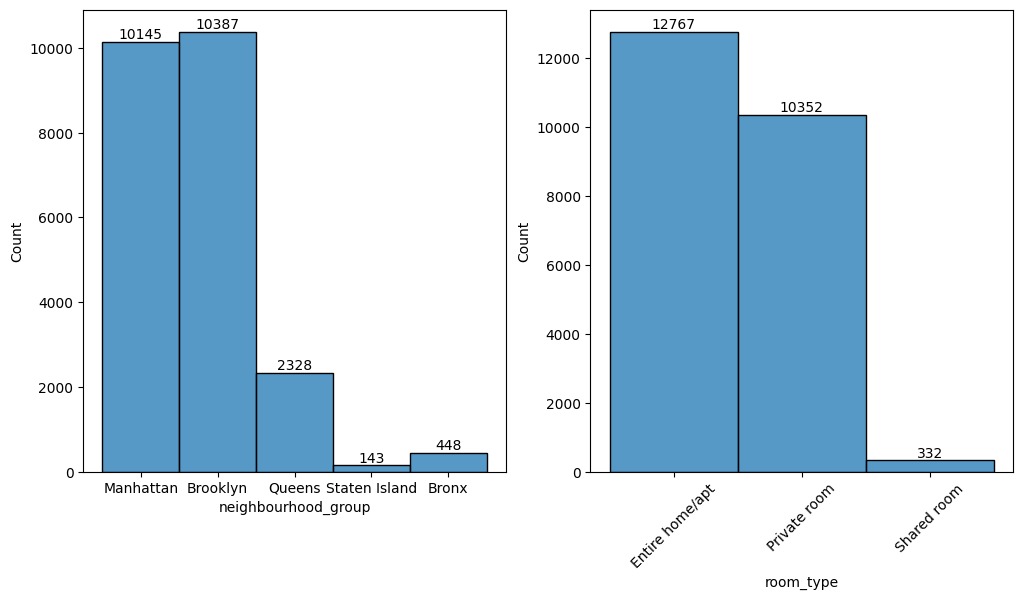

   neighbourhood_group  proportion
0                    1    0.442924
1                    0    0.432604
2                    2    0.099271
3                    4    0.019104
4                    3    0.006098
   room_type  proportion
0          0    0.544412
1          1    0.441431
2          2    0.014157


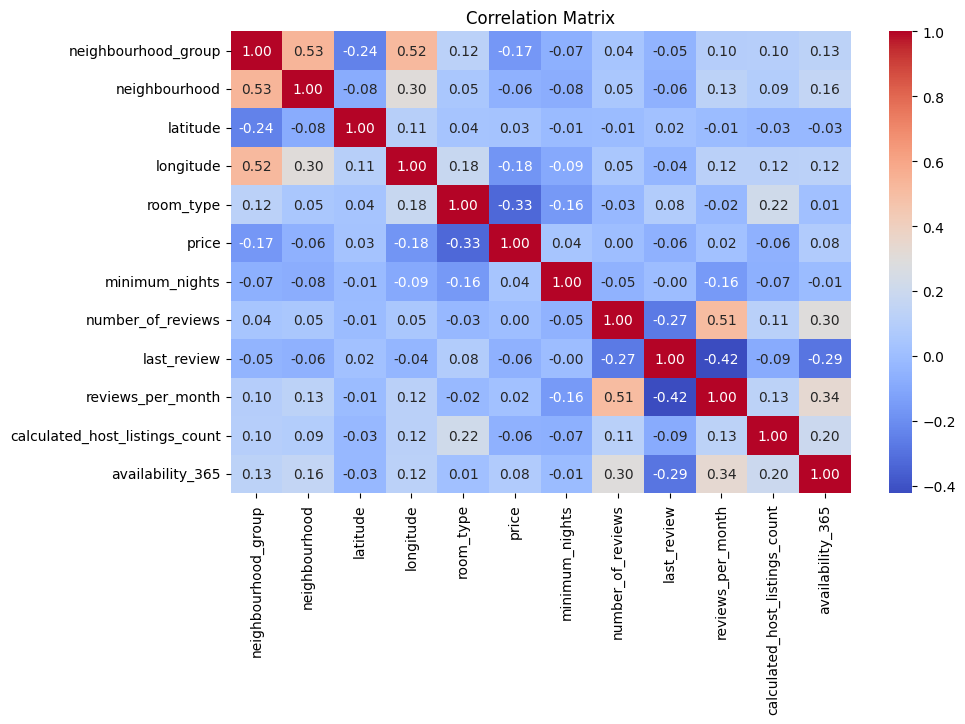

Selected Features: Index(['minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, SelectKBest

# Load dataset
# The dataset contains listings of NYC properties with various attributes.
nyc_data = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv')

# INITIAL SCREENING
# Display first few rows to understand the structure of the dataset.
print(nyc_data.head())
print("Dataset Shape:", nyc_data.shape)
print(nyc_data.info())  # Check data types and missing values
print(nyc_data.describe())  # Summary statistics for numerical columns

# PROBLEM STATEMENT
# Goal: Determine the factors influencing and determining property price per night.

# HANDLE DUPLICATES
# Check for duplicate rows, excluding 'id' as it's unique.
duplicates = nyc_data.drop('id', axis=1).duplicated().sum()
if duplicates != 0:
    nyc_data.drop_duplicates(subset=nyc_data.columns.difference(['id']), inplace=True)

# HANDLE NULL VALUES
# Identify missing values as a percentage of the total dataset.
nulls = nyc_data.isnull().sum() / len(nyc_data)
print("Percentage of Missing Values:")
print(nulls)

# REMOVE IRRELEVANT DIMENSIONS
# Columns 'id', 'name', 'host_id', and 'host_name' are not relevant for analysis.
nyc_data.drop(['id', 'name', 'host_id', 'host_name'], axis=1, inplace=True)

# REMOVE OUTLIERS
# Identifying and removing outliers using the Interquartile Range (IQR) method.
cols = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
for col in cols: 
    q1, q3 = nyc_data[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    nyc_data = nyc_data[(nyc_data[col] >= (q1 - 1.5 * iqr)) & (nyc_data[col] <= (q3 + 1.5 * iqr))]

print("Data Info After Cleaning:")
print(nyc_data.info())

# UNIVARIATE DATA ANALYSIS
# Analyze categorical and numerical variables.
cat_dimensions = nyc_data[['neighbourhood_group', 'neighbourhood', 'room_type', 'last_review']]
num_dimensions = nyc_data[['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]

# Convert categorical variables into numerical representations using label encoding
for col in ['neighbourhood_group', 'neighbourhood', 'room_type', 'last_review']:
    nyc_data[col] = pd.factorize(nyc_data[col])[0]

# Analyze distribution of categorical variables
fig, axis = plt.subplots(1,2, figsize=(12, 6))
sns.histplot(ax=axis[0], data=cat_dimensions, x='neighbourhood_group').bar_label(axis[0].containers[0])
sns.histplot(ax=axis[1], data=cat_dimensions, x='room_type').bar_label(axis[1].containers[0])
plt.xticks(rotation=45)
plt.show()

# Analyze the proportion of listings per neighborhood group and room type.
main_neighborhoods = nyc_data['neighbourhood_group'].value_counts(normalize=True).reset_index()
main_neighborhoods.columns = ['neighbourhood_group', 'proportion']
print(main_neighborhoods)

main_roomtypes = nyc_data['room_type'].value_counts(normalize=True).reset_index()
main_roomtypes.columns = ['room_type', 'proportion']
print(main_roomtypes)

# MULTIVARIATE ANALYSIS
# Correlation matrix to understand relationships between variables.
correlation_matrix = nyc_data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# NORMALIZE NUMERICAL VALUES
# Standardizing numerical variables to ensure uniformity.
X = nyc_data.drop('price', axis=1)[cols]
y = nyc_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns=cols)
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns=cols)

# FEATURE SELECTION
# Selecting the top 5 most relevant features using ANOVA F-test.
selection_model = SelectKBest(f_classif, k=5)
selection_model.fit(X_train_norm, y_train)
selected_features = X_train_norm.columns[selection_model.get_support()]
print("Selected Features:", selected_features)

# OBSERVED RESULTS
# Missing Data:
# The dataset contained missing values in the 'last_review' and 'reviews_per_month' columns, indicating that not all listings received recent reviews.
# Outliers:
# Extreme values were observed in 'minimum_nights' and 'price', suggesting some listings have exceptionally high minimum night requirements or prices.
# Neighborhood Insights:
# Brooklyn (44.29%) and Manhattan (43.26%) had the highest concentration of listings, dominating the NYC market.
# Other boroughs, such as Queens (9.93%), Bronx (1.91%), and Staten Island (0.61%), had significantly fewer listings.
# Room Type Distribution:
# Entire homes/apartments (54.44%) were the most listed accommodation type.
# Private rooms (44.14%) were also prevalent, while shared rooms (1.42%) were rare.
# Price Distribution:
# The price distribution was highly skewed, with a median around $106, but with some listings priced as high as $10,000.
# Reviews & Availability:
# Most listings had low review counts, with a few outliers having over 600 reviews.
# Many listings had 0 availability days, indicating inactive hosts or seasonal rentals.
# Correlation Insights:
# Latitude had weak correlation (0.03) with price, meaning location within NYC does not significantly impact price.
# Longitude had a stronger negative correlation (-0.18), suggesting that moving eastward is associated with lower prices.
# Availability 365 showed a weak positive correlation (0.08), meaning more available listings tend to have slightly higher prices.
# Feature Selection Results:
# The most relevant features for predicting price were:
# Minimum Nights
# Number of Reviews
# Reviews per Month
# Calculated Host Listings Count
# Availability 365